# <center> Modelo de ML </center>

## 1. Librerías

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, top_k_accuracy_score

## 2. Configuraciones

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
plt.rcParams["figure.figsize"] = (8, 5)
sns.set(style="whitegrid")

## 3. Carga de datos

In [10]:
DATA_PATH = "../Datasets/Refined/refined_data.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()

Shape: (9316, 10)


,codCliente,codPoliza,Ramo,Y,Salud,Vida,Autos,Cumplimiento,Patrimoniales,Otros
0,37,69,Vida,Autos,0,1,0,0,0,0
1,37,80568,Autos,Salud,0,1,1,0,0,0
2,84,118023,Autos,Vida,0,0,1,0,0,0
3,87,54,Vida,Salud,0,1,0,0,0,0
4,1356,206,Cumplimiento,Patrimoniales,0,0,0,1,0,0


## 4. Preprocesamiento de datos

In [11]:
id_cols = ["codCliente", "codPoliza"]
for col in id_cols:
    if col in df.columns:
        df = df.drop(columns = col)

### 4.1. Revisar desbalance entre clases

In [12]:
print(df["Y"].value_counts(normalize = True))

Y
Salud            0.285316
Patrimoniales    0.263847
Vida             0.223916
Autos            0.197939
Cumplimiento     0.022112
Otros            0.006870
Name: proportion, dtype: float64


### 4.2. Revisar nulos

In [13]:
df.isna().sum()

Ramo             0
Y                0
Salud            0
Vida             0
Autos            0
Cumplimiento     0
Patrimoniales    0
Otros            0
dtype: int64

## 5. Ingeniería de características

In [14]:
product_cols = ["Salud", "Vida", "Autos", "Cumplimiento", "Patrimoniales", "Otros"]

# Columna tamaño de portafolio
df["tam_portafolio"] = df[product_cols].sum(axis = 1)

# Columnas de interacciones
df["vida_salud_combo"] = (df["Vida"] & df["Salud"]).astype(int)
df["autos_patrimoniales_combo"] = (df["Autos"] & df["Patrimoniales"]).astype(int)

df.head()

,Ramo,Y,Salud,Vida,Autos,Cumplimiento,Patrimoniales,Otros,tam_portafolio,vida_salud_combo,autos_patrimoniales_combo
0,Vida,Autos,0,1,0,0,0,0,1,0,0
1,Autos,Salud,0,1,1,0,0,0,2,0,0
2,Autos,Vida,0,0,1,0,0,0,1,0,0
3,Vida,Salud,0,1,0,0,0,0,1,0,0
4,Cumplimiento,Patrimoniales,0,0,0,1,0,0,1,0,0


## 6. Definición features y target

In [15]:
TARGET = "Y"

X = df.copy().drop(columns = TARGET)
y = df[TARGET].copy()

# Column types for preprocessing
categorical_features = ["Ramo"]
numeric_features = [c for c in X.columns if c not in categorical_features]

X.head()

,Ramo,Salud,Vida,Autos,Cumplimiento,Patrimoniales,Otros,tam_portafolio,vida_salud_combo,autos_patrimoniales_combo
0,Vida,0,1,0,0,0,0,1,0,0
1,Autos,0,1,1,0,0,0,2,0,0
2,Autos,0,0,1,0,0,0,1,0,0
3,Vida,0,1,0,0,0,0,1,0,0
4,Cumplimiento,0,0,0,1,0,0,1,0,0


### 7. División del conjunto de datos

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.20,
    stratify = y,
    random_state = RANDOM_STATE,
)

print("Train size:", X_train.shape[0])
print("Test size: ", X_test.shape[0])

# We'll use this CV object later
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)


Train size: 7452
Test size:  1864


## 8. Pipelines de preprocesamiento

In [18]:
preprocess_for_trees = ColumnTransformer(
    transformers = [
        ("cat", OneHotEncoder(handle_unknown = "ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

preprocess_for_linear = ColumnTransformer(
    transformers = [
        ("cat", OneHotEncoder(handle_unknown = "ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features),
    ]
)

## 9. Función para la evaluación

In [19]:
def evaluate_model(name, model, X, y, average = "macro"):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average = average)
    
    print(f"=== {name} ===")
    print(f"Accuracy:        {acc:.4f}")
    print(f"F1 ({average}):   {f1:.4f}")
    print("\nReporte de clasificación:")
    print(classification_report(y, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred, labels = np.unique(y))
    cm_df = pd.DataFrame(cm, index = np.unique(y), columns = np.unique(y))
    
    plt.figure(figsize = (7, 5))
    sns.heatmap(cm_df, annot = True, fmt = "d", cmap = "Blues")
    plt.ylabel("Real")
    plt.xlabel("Predicción")
    plt.title(f"Matriz de confusión - {name}")
    plt.show()
    
    return {"accuracy": acc, "f1": f1}

Utilizar métricas @k

In [40]:
def topk_metrics_from_proba(y_true, proba, classes, ks=(1, 3, 5)):
    """
    Compute accuracy@k (hit rate), precision@k, and recall@k for single-label
    multiclass classification given predicted probabilities.

    For single-label problems:
        - accuracy@k = recall@k = (# of samples where true label is in top-k) / N
        - precision@k = (# of hits) / (N * k)

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
    proba  : array-like of shape (n_samples, n_classes)
             predicted probabilities, columns ordered as `classes`
    classes : array-like of shape (n_classes,)
              class labels (as in estimator.classes_)
    ks : iterable of ints
         values of k to compute metrics for

    Returns
    -------
    results : dict
        keys like 'acc@3', 'prec@3', 'recall@3'
    """

    y_true = np.asarray(y_true)
    proba = np.asarray(proba)
    class_index = {c: i for i, c in enumerate(classes)}

    # Convert y_true to class indices
    y_idx = np.array([class_index[y] for y in y_true])

    n_samples = y_true.shape[0]
    results = {}

    for k in ks:
        # Top-k indices per row
        # (argpartition is faster than full argsort)
        topk_idx = np.argpartition(-proba, kth=k-1, axis=1)[:, :k]

        # Check if true label index is in the top-k for each sample
        hits = np.any(topk_idx == y_idx[:, None], axis=1)
        n_hits = hits.sum()

        acc_k = n_hits / n_samples          # also recall@k for single-label
        prec_k = n_hits / (n_samples * k)   # "average precision per slot"

        results[f"acc@{k}"] = acc_k
        results[f"recall@{k}"] = acc_k      # same as accuracy@k here
        results[f"prec@{k}"] = prec_k

    return results


In [ ]:
def evaluate_model(name, model, X, y, ks=(1, 3, 5), average="macro", plot_cm=True):
    """
    Evaluate a multiclass classifier with both standard and top-k metrics.

    - Standard: accuracy, F1 (macro)
    - Ranking-style: accuracy@k, precision@k, recall@k using predict_proba
    """

    print(f"\n=== {name} ===")

    # ---- Standard hard-prediction metrics ----
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average=average)

    print(f"Accuracy (k=1): {acc:.4f}")
    print(f"F1-{average}:       {f1:.4f}")

    print("\nClassification report:")
    print(classification_report(y, y_pred))

    # Confusion matrix
    if plot_cm:
        cm = confusion_matrix(y, y_pred, labels=np.unique(y))
        cm_df = pd.DataFrame(cm, index=np.unique(y), columns=np.unique(y))
        plt.figure(figsize=(7, 5))
        sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
        plt.ylabel("True")
        plt.xlabel("Predicted")
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

    # ---- Top-k metrics using predict_proba ----
    if not hasattr(model, "predict_proba"):
        print("\n[WARN] Model does not support predict_proba; skipping top-k metrics.")
        return {"accuracy": acc, "f1": f1}

    proba = model.predict_proba(X)
    # For a Pipeline, model.classes_ is inside the final step
    if hasattr(model, "classes_"):
        classes = model.classes_
    else:
        # Assume a Pipeline with last step named 'model'
        classes = model.named_steps["model"].classes_

    topk_res = topk_metrics_from_proba(y, proba, classes, ks=ks)

    print("\nTop-k metrics:")
    for k in ks:
        print(
            f"  acc@{k}: {topk_res[f'acc@{k}']:.4f} | "
            f"prec@{k}: {topk_res[f'prec@{k}']:.4f} | "
            f"recall@{k}: {topk_res[f'recall@{k}']:.4f}"
        )

    # Also include sklearn's top_k_accuracy_score for sanity
    for k in ks:
        skl_topk = top_k_accuracy_score(y, proba, k=k, labels=classes)
        print(f"  sklearn top_k_accuracy_score@{k}: {skl_topk:.4f}")

    # Combine all metrics in one dict
    results = {"accuracy": acc, "f1": f1}
    results.update(topk_res)
    return results

**Interpretación:**

For each k:

acc@k / recall@k
= fraction of clients where the true next policy is in the top k recommendations.

e.g. acc@3 = 0.78 → for 78% of clients, the actual next policy is among the top 3 suggestions.

prec@k
= hits / (N * k) → average precision per recommended slot.

e.g. prec@3 = 0.30 → on average, 30% of the 3 recommended products are truly the next one.

(With exactly one relevant item per client, precision@k ≤ 1/k.)

These metrics are exactly the recommender-style ones you’d report in a “next-best product” project

## 10. Modelos

### 10.1. Modelo base: Regresión logística multinomial

In [35]:
logreg_pipeline = Pipeline(
    steps = [
        ("preprocess", preprocess_for_linear),
        ("model", LogisticRegression(
            max_iter = 1000,
            multi_class = "multinomial",
            n_jobs = -1,
            random_state = RANDOM_STATE,
        )),
    ]
)

# Cross-validation on the TRAIN set (do NOT touch test yet)
logreg_cv_scores = cross_val_score(
    logreg_pipeline,
    X_train,
    y_train,
    cv = cv,
    scoring = "f1_macro"
)

print("Logistic Regression - CV F1_macro scores:", logreg_cv_scores)
print("Logistic Regression - Mean CV F1_macro:", logreg_cv_scores.mean())

/Users/majonator/Documents/EAFIT/Maestría CD&A/2025-2/Proyecto integrador/pi-20252-perfilamiento/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/majonator/Documents/EAFIT/Maestría CD&A/2025-2/Proyecto integrador/pi-20252-perfilamiento/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/majonator/Documents/EAFIT/Maestría CD&A/2025-2/Proyecto integrador/pi-20252-perfilamiento/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be remove

Logistic Regression - CV F1_macro scores: [0.3373193  0.34621718 0.32674102 0.32970324 0.31869101]
Logistic Regression - Mean CV F1_macro: 0.33173434863919277


/Users/majonator/Documents/EAFIT/Maestría CD&A/2025-2/Proyecto integrador/pi-20252-perfilamiento/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [42]:
logreg_pipeline.fit(X_train, y_train)

/Users/majonator/Documents/EAFIT/Maestría CD&A/2025-2/Proyecto integrador/pi-20252-perfilamiento/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



=== Logistic Regression (test) ===
Accuracy (k=1): 0.5445
F1-macro:       0.3509

Classification report:
               precision    recall  f1-score   support

        Autos       0.67      0.17      0.28       369
 Cumplimiento       1.00      0.02      0.05        41
        Otros       0.00      0.00      0.00        13
Patrimoniales       0.83      0.49      0.62       492
        Salud       0.53      0.60      0.56       532
         Vida       0.45      0.94      0.60       417

     accuracy                           0.54      1864
    macro avg       0.58      0.37      0.35      1864
 weighted avg       0.63      0.54      0.51      1864



/Users/majonator/Documents/EAFIT/Maestría CD&A/2025-2/Proyecto integrador/pi-20252-perfilamiento/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/majonator/Documents/EAFIT/Maestría CD&A/2025-2/Proyecto integrador/pi-20252-perfilamiento/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/majonator/Documents/EAFIT/Maestría CD&A/2025-2/Proyecto integrador/pi-20252-perfilamiento/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: Unde

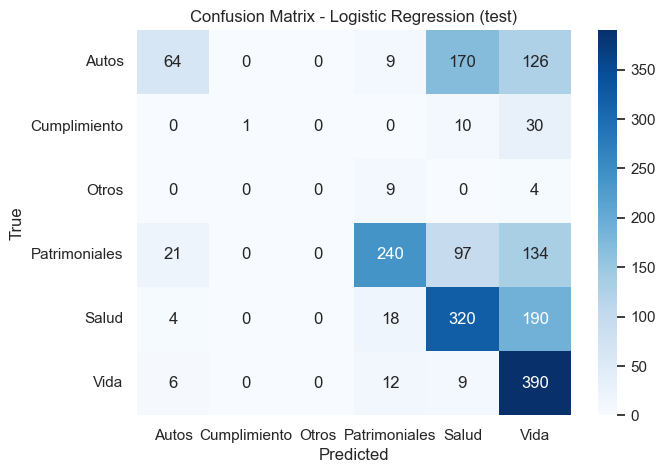


Top-k metrics:
  acc@1: 0.5445 | prec@1: 0.5445 | recall@1: 0.5445
  acc@3: 0.9683 | prec@3: 0.3228 | recall@3: 0.9683
  acc@5: 1.0000 | prec@5: 0.2000 | recall@5: 1.0000
  sklearn top_k_accuracy_score@1: 0.5445
  sklearn top_k_accuracy_score@3: 0.9683
  sklearn top_k_accuracy_score@5: 1.0000


In [43]:
logreg_test_results = evaluate_model(
    name="Logistic Regression (test)",
    model=logreg_pipeline,
    X=X_test,
    y=y_test,
    ks=(1, 3, 5)
)

### 10.2. HistGradientBoostingClassifier

In [ ]:
hgb_pipeline = Pipeline(
    steps = [
        ("preprocess", preprocess_for_trees),
        ("model", HistGradientBoostingClassifier(random_state = RANDOM_STATE)),
    ]
)

param_grid = {
    "model__max_depth": [None, 6, 10],
    "model__learning_rate": [0.05, 0.1],
    "model__max_iter": [200, 400],
    "model__min_samples_leaf": [20, 50],
}

grid_search = GridSearchCV(
    estimator = hgb_pipeline,
    param_grid = param_grid,
    cv = cv,
    scoring = "f1_macro",
    n_jobs = -1,
    verbose = 2,
)

print("Running GridSearchCV for HistGradientBoosting...")
grid_search.fit(X_train, y_train)

Running GridSearchCV for HistGradientBoosting...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=   6.3s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=   6.3s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=50; total time=   5.0s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=50; total time=   5.1s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=50; total time=   5.1s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=   6.1s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=   6.1s


In [44]:
best_hgb_model = grid_search.best_estimator_
best_hgb_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



=== HistGradientBoosting (test) ===
Accuracy (k=1): 0.5413
F1-macro:       0.3480

Classification report:
               precision    recall  f1-score   support

        Autos       0.64      0.17      0.26       369
 Cumplimiento       1.00      0.02      0.05        41
        Otros       0.00      0.00      0.00        13
Patrimoniales       0.85      0.48      0.61       492
        Salud       0.53      0.61      0.56       532
         Vida       0.44      0.92      0.60       417

     accuracy                           0.54      1864
    macro avg       0.58      0.37      0.35      1864
 weighted avg       0.62      0.54      0.51      1864



/Users/majonator/Documents/EAFIT/Maestría CD&A/2025-2/Proyecto integrador/pi-20252-perfilamiento/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/majonator/Documents/EAFIT/Maestría CD&A/2025-2/Proyecto integrador/pi-20252-perfilamiento/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/majonator/Documents/EAFIT/Maestría CD&A/2025-2/Proyecto integrador/pi-20252-perfilamiento/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: Unde

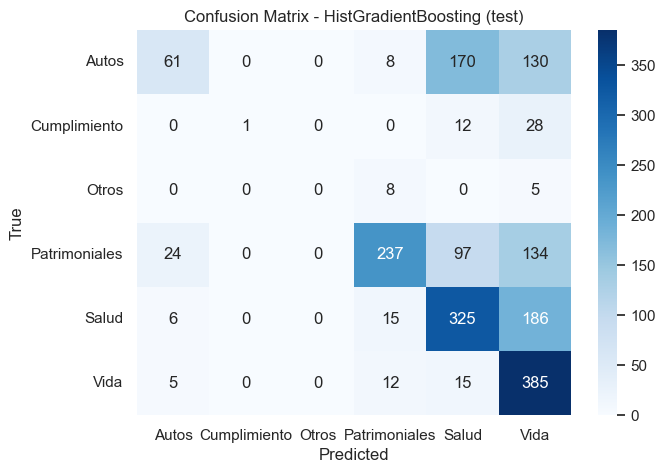


Top-k metrics:
  acc@1: 0.5413 | prec@1: 0.5413 | recall@1: 0.5413
  acc@3: 0.9683 | prec@3: 0.3228 | recall@3: 0.9683
  acc@5: 1.0000 | prec@5: 0.2000 | recall@5: 1.0000
  sklearn top_k_accuracy_score@1: 0.5413
  sklearn top_k_accuracy_score@3: 0.9683
  sklearn top_k_accuracy_score@5: 1.0000


{'accuracy': 0.5413090128755365,
 'f1': 0.3479870651901174,
 'acc@1': np.float64(0.5413090128755365),
 'recall@1': np.float64(0.5413090128755365),
 'prec@1': np.float64(0.5413090128755365),
 'acc@3': np.float64(0.9683476394849786),
 'recall@3': np.float64(0.9683476394849786),
 'prec@3': np.float64(0.32278254649499283),
 'acc@5': np.float64(1.0),
 'recall@5': np.float64(1.0),
 'prec@5': np.float64(0.2)}

In [45]:
hgb_test_results = evaluate_model(
    name = "HistGradientBoosting (test)",
    model = best_hgb_model,
    X = X_test,
    y = y_test,
    ks = (1, 3, 5)
)

hgb_test_results


Logistic Regression mean CV F1_macro: 0.33173434863919277
Best HistGradientBoosting mean CV F1_macro: 0.33736444625546785

>> Using HistGradientBoosting as final model.

=== FINAL EVALUATION ON TEST SET ===
=== Final Model (test) ===
Accuracy:        0.5413
F1 (macro):   0.3480

Reporte de clasificación:
               precision    recall  f1-score   support

        Autos       0.64      0.17      0.26       369
 Cumplimiento       1.00      0.02      0.05        41
        Otros       0.00      0.00      0.00        13
Patrimoniales       0.85      0.48      0.61       492
        Salud       0.53      0.61      0.56       532
         Vida       0.44      0.92      0.60       417

     accuracy                           0.54      1864
    macro avg       0.58      0.37      0.35      1864
 weighted avg       0.62      0.54      0.51      1864



/Users/majonator/Documents/EAFIT/Maestría CD&A/2025-2/Proyecto integrador/pi-20252-perfilamiento/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/majonator/Documents/EAFIT/Maestría CD&A/2025-2/Proyecto integrador/pi-20252-perfilamiento/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/majonator/Documents/EAFIT/Maestría CD&A/2025-2/Proyecto integrador/pi-20252-perfilamiento/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: Unde

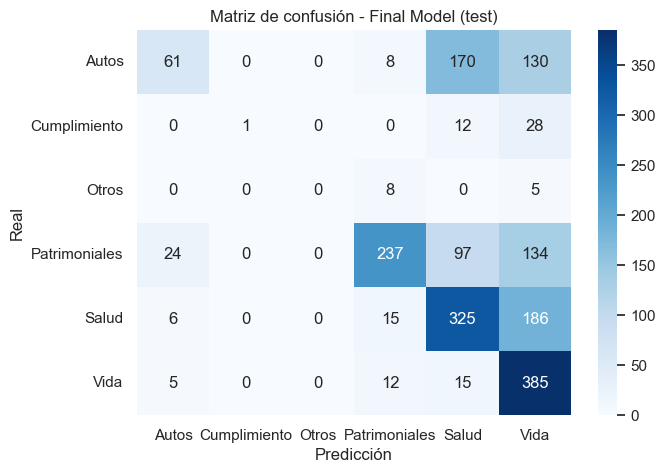

Test metrics dict: {'accuracy': 0.5413090128755365, 'f1': 0.3479870651901174}


In [38]:
print("\nLogistic Regression mean CV F1_macro:", logreg_cv_scores.mean())
print("Best HistGradientBoosting mean CV F1_macro:", grid_search.best_score_)

use_boosting_as_final = grid_search.best_score_ >= logreg_cv_scores.mean()

if use_boosting_as_final:
    print("\n>> Using HistGradientBoosting as final model.")
    final_model = grid_search.best_estimator_
else:
    print("\n>> Using Logistic Regression as final model.")
    # Refit baseline model on full train
    final_model = logreg_pipeline
    final_model.fit(X_train, y_train)

print("\n=== FINAL EVALUATION ON TEST SET ===")
test_results = evaluate_model("Final Model (test)", final_model, X_test, y_test)
print("Test metrics dict:", test_results)
